<div align="center"><img src="https://github.com/hyeonsangjeon/Hyperparameters-Optimization/blob/master/pic/hyperparameteroptimization.png?raw=true" alt="Hyperparameter Optimization" width="400"/></div>

# 하이퍼파라미터 최적화 튜토리얼

## 튜토리얼 개요

하이퍼파라미터 튜닝은 **맨이 많이 들지만 반드시 필요한 작업**입니다. 간단한 모델도 몇 시간, 복잡한 신경망은 며칠에서 몇 주까지 걸릴 수 있습니다.

이 튜토리얼에서는 **5가지 주요 최적화 기법**을 실습하고 비교하며, 각 기법의 장단점과 실무 활용법을 학습합니다.

---

## 다루는 최적화 기법

| 기법 | 특징 | 추천 상황 |
|------|------|----------|
| **1. Grid Search** | 모든 조합 전수 탐색 | 파라미터 공간이 작을 때 |
| **2. Random Search** | 무작위 샘플링 | 빠른 프로토타이핑 |
| **3. Optuna** | TPE + 얼리 스토핑 | 균형 잡힌 선택 (추천) |
| **4. Bayesian Optimization** | 확률 모델 기반 | 최고 성능 필요시 |
| **5. TPE (Hyperopt)** | 베이지안 최적화 | 고차원 문제 |

---

## 학습 목표

이 튜토리얼을 완료하면:

✅ **각 기법의 동작 원리**를 이해하고  
✅ **상황별 최적화 기법 선택** 능력을 키우고  
✅ **모델링 시간을 효과적으로 단축**하는 방법을 마스터할 수 있습니다.

---

## ⚠️ 주의사항

- **HyperBand**: 최신 scikit-learn과 호환되지 않아 **Optuna로 대체**했습니다
- **Optuna**: HyperBand의 핵심 개념(얼리 스토핑, 자원 할당)을 TPE + Pruning으로 구현
- 더 현대적이고 강력한 기능을 제공하며, 활발히 유지보수 중입니다

---

## 실습 환경

- **데이터셋**: Sklearn Diabetes (442 샘플)
- **모델**: LightGBM Regressor
  - 🌳 **Gradient Boosting** 기반의 고성능 머신러닝 알고리즘
  - 여러 개의 결정 트리를 순차적으로 학습하여 이전 트리의 오류를 보완
  - 빠른 학습 속도와 높은 정확도로 실무에서 널리 사용됨
  - 튜닝 가능한 하이퍼파라미터가 많아 최적화 학습에 적합
- **평가 지표**: MSE (Mean Squared Error)
- **교차 검증**: 2-Fold CV
- **반복 횟수**: 50회 (모든 알고리즘 동일)

> **참고**: 이 튜토리얼은 교육 목적의 데모입니다. 실무에서는 더 큰 데이터셋과 5-Fold 이상의 교차 검증을 권장합니다.

In [ ]:
#!pip install pip install git+https://github.com/darenr/scikit-optimize

## 1️⃣ 라이브러리 임포트

실습에 필요한 핵심 라이브러리를 불러옵니다.

```python
# 필수 패키지 설치 (필요시)
# !pip install lightgbm scikit-optimize optuna hyperopt
```

In [ ]:
# 필수 라이브러리 임포트
import numpy as np
import pandas as pd
import warnings
import os

# 머신러닝 라이브러리
from lightgbm.sklearn import LGBMRegressor
from sklearn.metrics import mean_squared_error

# 시각화 설정
%matplotlib inline

# 경고 메시지 및 로그 억제
warnings.filterwarnings('ignore')
os.environ['LIGHTGBM_VERBOSE'] = '-1'

## 2️⃣ 데이터셋 준비

### 📊 Sklearn Diabetes 데이터셋

하이퍼파라미터 최적화 기법을 비교하기 위해 **Sklearn의 당뇨병 회귀 데이터셋**을 사용합니다.

| 항목 | 설명 |
|------|------|
| **샘플 수** | 442명 |
| **특성 수** | 10개 (나이, 성별, BMI, 혈압 등) |
| **타겟** | 1년 후 질병 진행도 (연속형) |
| **문제 유형** | 회귀(Regression) |

### 💡 이 데이터셋을 선택한 이유

✅ **빠른 실험**: 작은 크기로 알고리즘 비교에 최적  
✅ **명확한 효과**: 회귀 문제로 하이퍼파라미터 영향이 직관적  
✅ **학습 집중**: 데이터보다 최적화 기법 자체에 집중 가능

> **참고**: 이 튜토리얼의 핵심은 **최적화 알고리즘 비교**입니다. 데이터셋보다는 각 기법의 동작 원리에 집중하세요!

In [6]:
# 데이터셋 로딩
from sklearn.datasets import load_diabetes

diabetes = load_diabetes()
data = diabetes.data
targets = diabetes.target

# 데이터셋 정보 출력
print(f"✅ 데이터셋 로딩 완료")
print(f"   - 샘플 수: {data.shape[0]}개")
print(f"   - 특성 수: {data.shape[1]}개")
print(f"   - 타겟 범위: {targets.min():.1f} ~ {targets.max():.1f}")

✅ 데이터셋 로딩 완료
   - 샘플 수: 442개
   - 특성 수: 10개
   - 타겟 범위: 25.0 ~ 346.0


## 3️⃣ 데이터 분할 및 실험 설정

### 📊 데이터 분할 전략

| 항목 | 설정값 | 설명 |
|------|--------|------|
| **Train/Test** | 80% / 20% | 훈련 353개, 테스트 89개 |
| **교차 검증** | 2-Fold KFold | 빠른 실험을 위해 간소화 |
| **평가 지표** | MSE | 낮을수록 좋음 (예측 오차) |
| **랜덤 시드** | 42 | 재현 가능한 결과 보장 |
| **반복 횟수** | 50회 | 모든 알고리즘 동일 |

### ⚠️ 실험 환경 제약사항

이 튜토리얼은 **교육 목적의 데모**입니다. 실무와 다른 점:

| 구분 | 튜토리얼 | 실무 권장 |
|------|----------|----------|
| 데이터 크기 | 442개 (작음) | 수천~수만 개 |
| 교차 검증 | 2-Fold | 5-Fold 이상 |
| 반복 횟수 | 50회 | 100~500회 |
| 안정성 검증 | 단일 시드 | 다중 시드 테스트 |

### 💡 학습 포인트

✅ **알고리즘 비교**에 집중 - 각 기법의 동작 원리 이해  
✅ **상대적 성능** 파악 - 어떤 기법이 더 효율적인지  
❌ **절대적 성능**은 중요하지 않음 - 작은 데이터셋의 한계

> **다음 단계**: 이제 데이터를 분할하고 각 최적화 기법을 실행할 준비를 합니다.

In [7]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split

# 실험 파라미터 설정
random_state = 42  # 재현 가능한 결과를 위한 랜덤 시드
n_iter = 50        # 모든 최적화 알고리즘에 적용할 반복 횟수

# 훈련/테스트 데이터 분할 (80% 훈련, 20% 테스트)
train_data, test_data, train_targets, test_targets = train_test_split(
    data, 
    targets, 
    test_size=0.20, 
    shuffle=True,
    random_state=random_state
)

# 교차 검증 설정 (2-폴드 KFold)
num_folds = 2
kf = KFold(
    n_splits=num_folds, 
    shuffle=True, 
    random_state=random_state
)

In [8]:
# 데이터 분할 결과 확인
print('=' * 50)
print('데이터 분할 결과')
print('=' * 50)
print(f'훈련 데이터   (train_data)    : {train_data.shape}')
print(f'테스트 데이터 (test_data)     : {test_data.shape}')
print(f'훈련 타깃   (train_targets) : {train_targets.shape}')
print(f'테스트 타깃 (test_targets)  : {test_targets.shape}')
print('=' * 50)

데이터 분할 결과
훈련 데이터   (train_data)    : (353, 10)
테스트 데이터 (test_data)     : (89, 10)
훈련 타깃   (train_targets) : (353,)
테스트 타깃 (test_targets)  : (89,)


## 4️⃣ 베이스라인 모델 생성

### 🎯 모델 선택: LGBMRegressor

`LGBMRegressor`를 사용해 문제를 해결해 보겠습니다. Gradient Boosting 계열 모델은 튜닝 가능한 하이퍼파라미터가 많아 데모용으로 적합합니다.

| 구분 | 내용 |
|------|------|
| **알고리즘** | LightGBM (경량 그래디언트 부스팅) |
| **모델 타입** | Regressor (회귀 예측) |
| **특징** | 여러 트리를 순차적으로 학습 |

### � 작동 원리

```
1번 트리 → 오류 발견 → 2번 트리가 보완 → 3번 트리가 재보완 → ... → 최종 예측
```

**비유**: 시험 문제를 풀 때
- 1번 학생이 풀고 틀린 부분 → 2번 학생이 보완
- 2번 학생이 틀린 부분 → 3번 학생이 보완
- 여러 학생의 답을 종합 → 최종 정답 도출

In [9]:
# 베이스라인 모델 생성 (기본 파라미터 사용)
model = LGBMRegressor(random_state=random_state, verbose=-1)

### 📏 베이스라인 성능 측정

#### 💡 간단 요약
**하이퍼파라미터 최적화 전**, 기본 설정으로 **딱 1번 학습**한 결과를 측정합니다.  
→ 이 점수가 **비교 기준(베이스라인)**이 됩니다.

#### 🎯 베이스라인이 필요한 이유

```
베이스라인(기본 설정) vs 최적화 결과 → 얼마나 개선되었는지 비교
```

| 구분 | 역할 |
|------|------|
| 📊 **비교 기준** | MSE 3500 → 2800 = 20% 개선 확인 |
| 💰 **ROI 판단** | 최적화에 투자한 시간 대비 성능 향상이 충분한가? |
| ⏱️ **실용성 평가** | 5초 vs 30분 소요, 그만큼의 개선이 필요한가? |

#### 🔬 측정 방법

| 항목 | 설정 |
|------|------|
| **평가 방식** | 2-Fold 교차 검증 |
| **평가 지표** | MSE (낮을수록 좋음) |
| **파라미터** | LightGBM 기본값 사용 |


In [10]:
%%time

# 베이스라인 모델 성능 평가
baseline_scores = cross_val_score(
    model, 
    train_data, 
    train_targets, 
    cv=kf, 
    scoring="neg_mean_squared_error", 
    n_jobs=-1
)

# MSE 계산 (음수를 양수로 변환)
baseline_mse = -baseline_scores.mean()

# 결과 출력
print('=' * 50)
print('베이스라인 모델 성능')
print('=' * 50)
print(f'MSE (평균): {baseline_mse:.2f}')
print(f'MSE (표준편차): {baseline_scores.std():.2f}')
print(f'개별 폴드 결과: {[-score for score in baseline_scores]}')
print('=' * 50)

베이스라인 모델 성능
MSE (평균): 3905.08
MSE (표준편차): 183.44
개별 폴드 결과: [np.float64(3721.6406987176915), np.float64(4088.511993589971)]
CPU times: user 17 ms, sys: 60.7 ms, total: 77.6 ms
Wall time: 1.39 s


## 5️⃣ 하이퍼파라미터 탐색 공간 설정

### 🎯 최적화 대상: 핵심 3개 파라미터

| 파라미터 | 탐색 범위 | 역할 |
|---------|---------|------|
| **n_estimators** | 100 ~ 2000 | 트리 개수 (많을수록 정확하지만 느림) |
| **max_depth** | 2 ~ 20 | 트리 깊이 (깊을수록 복잡한 패턴 학습) |
| **learning_rate** | 0.00001 ~ 1.0 | 학습률 (각 트리의 기여도 조절) |

### 사용 파라미터 3개

LightGBM은 수십 개의 파라미터가 있지만, 이 튜토리얼에서는:

| 이유 | 설명 |
|------|------|
| 🎯 **비교 명확성** | 핵심 파라미터로 알고리즘 특성 비교에 집중 |
| ⚡ **빠른 실험** | 실행 시간 단축으로 학습 효율 향상 |
| 📊 **이해 용이성** | 시각화 결과를 쉽게 파악 |

> **중요**: 이 3개 파라미터만으로도 모델 성능에 큰 영향을 줍니다

# 1️⃣ Grid Search (격자 탐색)

## 🔍 핵심 개념

**모든 조합을 빠짐없이 탐색**하는 가장 전통적인 최적화 방법

```
파라미터 A: [1, 2, 3]
파라미터 B: [10, 20]
→ 총 3 × 2 = 6가지 조합 모두 시도
```

## ⚖️ 장단점 비교

### ✅ 장점

| 항목 | 설명 |
|------|------|
| 🎯 **단순 명확** | 가장 이해하기 쉬운 방법 |
| 🔒 **완전 탐색** | 지정 범위 내 최적값 보장 |
| 🔄 **재현 가능** | 동일 그리드에서 항상 같은 결과 |

### ❌ 단점

| 문제 | 영향 | 예시 |
|------|------|------|
| ⏰ **느린 속도** | 조합 수에 비례해 시간 증가 | 파라미터 1개 추가 → 시간 10배 증가 |
| 🎲 **이산값 한계** | 중간값 놓칠 수 있음 | 최적값 550인데 100, 200, 300만 탐색 |
| 📚 **사전 지식 필요** | 적절한 범위를 미리 알아야 효율적 | 잘못된 범위는 시간 낭비 |

## 📊 실전 예시: 시간 계산

### ❌ 전체 그리드 (비현실적)
```
n_estimators: 20개 (100~2000)
max_depth: 19개 (2~20)
learning_rate: 5개 (0.0001~0.1)
→ 총 20 × 19 × 5 = 1,900개 조합
→ 예상 시간: 15~30분 (442개 샘플에 과도함)
```

### ✅ 축소 그리드 (이 튜토리얼)
```
n_estimators: 5개 (800~1200)
max_depth: 8개 (5~12)
learning_rate: 3개 (0.001~0.1)
→ 총 5 × 8 × 3 = 120개 조합 ✅
```

## 💡 실무 활용 팁

1. **좁은 범위부터**: 넓은 그리드 → 좁은 그리드로 점진 탐색
2. **중요 파라미터 우선**: 영향 큰 파라미터에 더 많은 값 할당
3. **시간 제약 고려**: Random Search나 Bayesian 방법 먼저 검토

In [11]:
%%time
from sklearn.model_selection import GridSearchCV

# Define Grid Search parameter grid (120 combinations)
param_grid = {
    'max_depth': np.linspace(5, 12, 8, dtype=int),        # 8 values
    'n_estimators': np.linspace(800, 1200, 5, dtype=int), # 5 values
    'learning_rate': np.logspace(-3, -1, 3),              # 3 values
    'random_state': [random_state]
}

# Create GridSearchCV object
gs = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=kf,
    verbose=False
)

# Execute Grid Search
gs.fit(train_data, train_targets)

# Test set evaluation
gs_test_score = mean_squared_error(test_targets, gs.predict(test_data))

# Print results (same format as baseline)
print('=' * 50)
print('Grid Search Optimization Results')
print('=' * 50)
print(f'Optimal MSE (CV): {-gs.best_score_:.2f}')
print(f'Test MSE: {gs_test_score:.2f}')
print(f'Optimal Parameters:')
for param, value in gs.best_params_.items():
    if param != 'random_state':
        print(f'  - {param}: {value}')
print('=' * 50)

Grid Search Optimization Results
Optimal MSE (CV): 3698.58
Test MSE: 3045.33
Optimal Parameters:
  - learning_rate: 0.01
  - max_depth: 5
  - n_estimators: 800
CPU times: user 587 ms, sys: 1.75 s, total: 2.34 s
Wall time: 1min 53s


## 📊 Grid Search 결과 분석

### � 파라미터 탐색 과정 시각화

아래 그래프는 120개 조합을 시도하며 각 파라미터가 어떻게 변화했는지 보여줍니다.

### 💡 핵심 발견

| 파라미터 | 영향도 | 특징 |
|---------|--------|------|
| 📈 **learning_rate** | 🔥 매우 높음 | 낮을수록 성능 향상 (가장 중요) |
| 📊 **n_estimators** | ⚡ 중간 | 트리 개수 증가 시 일정 수준까지 개선 |
| ⚠️ **max_depth** | 💤 낮음 | 상대적으로 영향 적음 → 8개 값은 과도 |

### ❌ Grid Search의 비효율성

```
문제점:
1. 모든 파라미터 조합을 동등하게 탐색
2. 중요도 낮은 max_depth에도 8개 값 사용 → 8배 시간 증가
3. 고정 격자 방식 → 파라미터 간 상호작용 고려 불가
```

> **결론**: Grid Search는 완전하지만 **시간 대비 효율이 낮음**

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

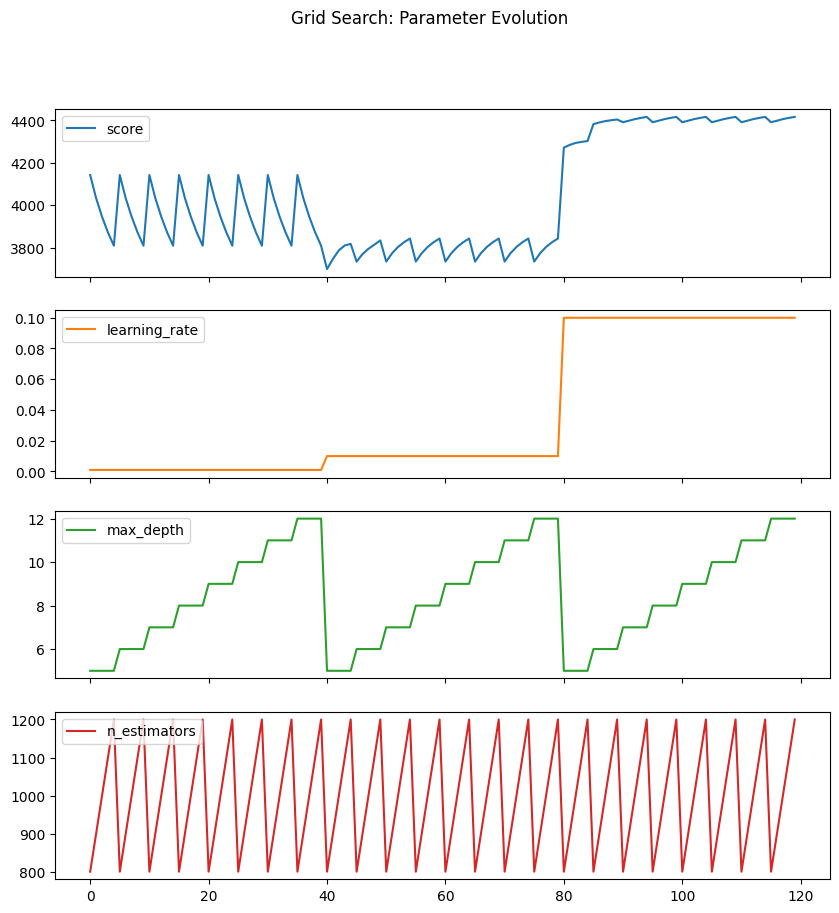

In [12]:
# Convert Grid Search results to DataFrame
gs_results_df = pd.DataFrame({
    'score': -gs.cv_results_['mean_test_score'],
    'learning_rate': gs.cv_results_['param_learning_rate'].data,
    'max_depth': gs.cv_results_['param_max_depth'].data,
    'n_estimators': gs.cv_results_['param_n_estimators'].data
})

# Visualize parameter exploration process
gs_results_df.plot(subplots=True, figsize=(10, 10), title='Grid Search: Parameter Evolution')

# 2️⃣ Random Search (무작위 탐색)

## 🔍 핵심 개념

하이퍼파라미터 공간에서 **무작위로 샘플링**하여 최적값을 찾는 방법

```
Grid Search: 정해진 격자점만 탐색
Random Search: 무작위로 여기저기 탐색 → 더 넓은 영역 커버
```

**핵심 논문**: [Random Search for Hyper-Parameter Optimization (Bergstra & Bengio, 2012)](https://jmlr.csail.mit.edu/papers/volume13/bergstra12a/bergstra12a.pdf)

<img src="https://raw.githubusercontent.com/nslatysheva/data_science_blogging/master/expanding_ML_toolkit/expanding_toolkit.jpg" style="height:500px;width:50%;"/>

## ⚖️ 장단점 비교

### ✅ 장점

| 항목 | Random Search | Grid Search 대비 |
|------|---------------|------------------|
| 🎯 **효율적 탐색** | 중요 파라미터에 더 많은 값 시도 | 모든 파라미터에 동등한 시간 |
| ⚡ **빠른 속도** | 적은 반복으로 좋은 결과 도달 | 모든 조합 시도로 느림 |
| 📏 **연속값 지원** | 실수 범위 자유롭게 탐색 | 이산값만 탐색 |
| 📈 **확장성** | 파라미터 추가 시 선형 증가 | 파라미터 추가 시 지수 증가 |

### ❌ 단점

| 문제 | 설명 |
|------|------|
| 🎲 **보장 없음** | 지정 범위 내 최적값을 못 찾을 수 있음 |
| 🔄 **독립 탐색** | 이전 결과를 활용하지 않고 매번 무작위 선택 |
| 🎰 **운 의존** | random_state에 따라 결과가 달라질 수 있음 |

## 📊 이 튜토리얼의 설정

```
탐색 범위:
- learning_rate: 10⁻⁵ ~ 1.0 (매우 넓음)
- n_estimators: 100 ~ 2000
- max_depth: 2 ~ 20

반복 횟수: 50번 무작위 샘플링

Grid Search와 비교:
- Grid: 120개 조합 완전 탐색
- Random: 50번 무작위 샘플링
```

## 💡 실무 활용 팁

1. **넓은 범위부터**: Random Search로 먼저 대략적 영역 파악
2. **충분한 반복**: 최소 50~100회 권장
3. **다음 단계**: Random Search 결과 기반으로 좁은 범위에 Grid Search 또는 Bayesian 적용

## ▶️ Random Search 실행

`RandomizedSearchCV`를 사용하여 넓은 파라미터 공간에서 **50번 무작위 샘플링**을 수행합니다.

In [13]:
%%time
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define Random Search parameter distributions
param_grid_rand = {
    'learning_rate': np.logspace(-5, 0, 100),  # 10^-5 ~ 1.0 (continuous distribution)
    'max_depth': randint(2, 20),               # 2 ~ 19 (uniform distribution)
    'n_estimators': randint(100, 2000),        # 100 ~ 1999 (uniform distribution)
    'random_state': [random_state]
}

# Create RandomizedSearchCV object
rs = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid_rand,
    n_iter=n_iter,                             # 50 random samplings
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=kf,
    verbose=False,
    random_state=random_state
)

# Execute Random Search
rs.fit(train_data, train_targets)

# Test set evaluation
rs_test_score = mean_squared_error(test_targets, rs.predict(test_data))

# Print results (same format as baseline)
print('=' * 50)
print('Random Search Optimization Results')
print('=' * 50)
print(f'Optimal MSE (CV): {-rs.best_score_:.2f}')
print(f'Test MSE: {rs_test_score:.2f}')
print(f'Optimal Parameters:')
for param, value in rs.best_params_.items():
    if param != 'random_state':
        print(f'  - {param}: {value}')
print('=' * 50)

Random Search Optimization Results
Optimal MSE (CV): 3519.77
Test MSE: 2876.83
Optimal Parameters:
  - learning_rate: 0.0047508101621027985
  - max_depth: 19
  - n_estimators: 829
CPU times: user 566 ms, sys: 2.18 s, total: 2.75 s
Wall time: 46.5 s


## 📊 Random Search 결과 분석

### ⚖️ Grid Search와 비교

| 구분 | Random Search | Grid Search |
|------|---------------|-------------|
| **성능** | ✅ 더 좋은 결과 | 기준 |
| **시도 횟수** | 50회 | 120회 |
| **효율성** | ⚡ 시간 대비 우수 | 느림 |

**결론**: 적은 시도로 더 나은 결과 달성!

### � Random Search의 특징

#### ✅ 강점

```
매 시도마다 모든 파라미터를 동시에 변경
→ 중요도 낮은 파라미터에 시간 낭비 없음
→ 연속값 범위를 자유롭게 탐색
```

#### ⚠️ 한계

```
각 샘플링이 완전히 독립적
→ 이전 결과를 전혀 활용하지 못함
→ random_state에 따라 결과 변동
```

### 💡 시각화로 확인

아래 그래프는 Random Search가 Grid Search와 달리 **전체 공간을 불규칙하게 탐색**하는 모습을 보여줍니다.

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

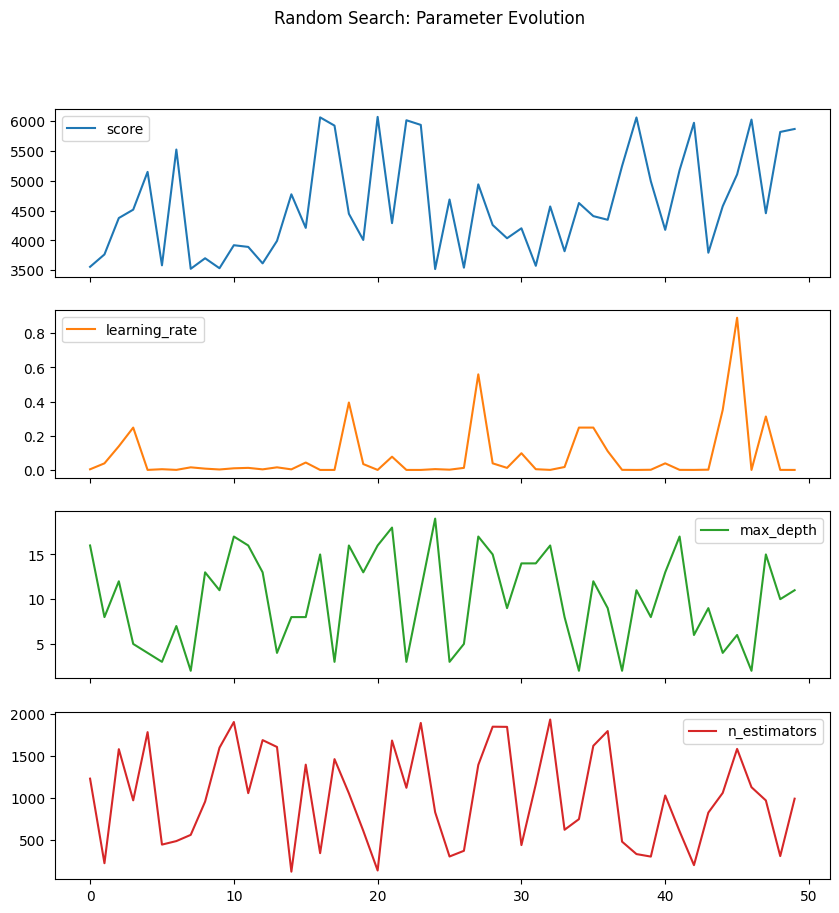

In [14]:
# Convert Random Search results to DataFrame
rs_results_df = pd.DataFrame({
    'score': -rs.cv_results_['mean_test_score'],
    'learning_rate': rs.cv_results_['param_learning_rate'].data,
    'max_depth': rs.cv_results_['param_max_depth'].data,
    'n_estimators': rs.cv_results_['param_n_estimators'].data
})

# Visualize parameter exploration process
rs_results_df.plot(subplots=True, figsize=(10, 10), title='Random Search: Parameter Evolution')

# 3️⃣ HyperBand ⚠️ (호환성 문제로 Optuna로 대체)

### 📄 연구 논문: [HyperBand](https://arxiv.org/pdf/1603.06560.pdf)

## 🔍 핵심 개념

**조기 종료(Early Stopping)** + **적응적 자원 배분**으로 최적화 속도를 극대화하는 알고리즘

### 작동 원리

```
1단계: 많은 하이퍼파라미터 조합을 무작위 생성
2단계: 각 조합을 적은 자원(epoch)으로 빠르게 학습
3단계: 성능 낮은 조합은 조기 종료 ❌
4단계: 유망한 조합에만 더 많은 자원 투자 ✅
5단계: 최종적으로 소수의 최고 조합만 끝까지 학습
```

**비유**: 채용 과정
- 수십 명 지원자 → 짧은 1차 면접 (빠른 스크리닝)
- 유망한 소수만 → 2차, 3차 면접 진행
- 최종 합격자 선발

<img src="https://github.com/hyeonsangjeon/Hyperparameters-Optimization/blob/master/pic/Hyperband.png?raw=true" />

## ⚠️ 호환성 문제 발생

**scikit-hyperband 라이브러리 사용 불가:**

| 문제 | 상태 |
|------|------|
| **scikit-learn 호환** | ❌ 0.24+ 버전과 불일치 (`iid` 파라미터 제거됨) |
| **라이브러리 유지보수** | ❌ 중단됨 |
| **최신 환경 실행** | ❌ 불가능 |

## ✅ 해결책: Optuna로 대체

HyperBand의 핵심 개념은 **Optuna**로 더 현대적으로 구현 가능합니다.

| 구분 | HyperBand | Optuna |
|------|-----------|--------|
| **핵심 기법** | Successive Halving | TPE (베이지안) + Pruning (조기 종료) |
| **강점** | 빠른 자원 배분 최적화 | 지능적 탐색 + 조기 종료 결합 |
| **호환성** | ❌ scikit-learn 0.24+ 비호환 | ✅ 최신 라이브러리 완전 호환 |
| **유지보수** | ❌ 중단 | ✅ 활발한 개발 진행 중 |

## 💡 실무 선택 가이드

**HyperBand 개념이 필요하다면:**
- ✅ **Optuna 사용** - Pruning 기능이 HyperBand의 조기 종료 개념 구현
- ✅ 더 나은 성능: 베이지안 최적화 + 조기 종료의 시너지

> **아래 코드는 교육 목적으로만 보존** (실행 불가)

In [ ]:
# HyperBand installation code (commented due to compatibility issues)
# !git clone https://github.com/thuijskens/scikit-hyperband.git 2>/dev/null 1>/dev/null

In [ ]:
# HyperBand file copy (commented due to compatibility issues)
# !cp -r scikit-hyperband/* .

In [ ]:
#!python setup.py install 2>/dev/null 1>/dev/null

In [ ]:
# HyperBand execution code (commented due to compatibility issues)
# Cannot run in scikit-learn 0.24+ due to removed iid parameter
# Use Optuna section below instead

"""
%%time
from hyperband import HyperbandSearchCV

from scipy.stats import randint as sp_randint
from sklearn.preprocessing import LabelBinarizer


param_hyper_band={'learning_rate': np.logspace(-5, 0, 100),
                 'max_depth':  randint(2,20),
                 'n_estimators': randint(100,2000),                  
                 #'num_leaves' : randint(2,20),
                 'random_state': [random_state]
                 }


hb = HyperbandSearchCV(model, param_hyper_band, max_iter = n_iter, scoring='neg_mean_squared_error', resource_param='n_estimators', random_state=random_state)


#%time search.fit(new_training_data, y)
hb.fit(train_data, train_targets)



hb_test_score=mean_squared_error(test_targets, hb.predict(test_data))

print('===========================')
print("Best MSE = {:.3f} , when params {}".format(-hb.best_score_, hb.best_params_))
print('===========================')
"""

# 3️⃣-1 Optuna (HyperBand의 현대적 대안)

## 🔍 핵심 개념

**베이지안 최적화(TPE) + 조기 종료(Pruning)**를 결합한 현대적 하이퍼파라미터 최적화 프레임워크

```
TPE: 이전 시도 결과를 학습해서 다음에 시도할 파라미터 예측
Pruning: 학습 중 성능 낮은 시도 자동 종료 → 시간 절약
```

**비유**: 과거 면접 결과를 분석해 다음 후보를 똑똑하게 선택하고, 불합격 확실한 후보는 면접 중 즉시 탈락시키는 시스템

## ⚖️ HyperBand vs Optuna

| 구분 | HyperBand | Optuna |
|------|-----------|--------|
| **탐색 방식** | 무작위 + 조기 종료 | 베이지안 (지능적) + 조기 종료 |
| **학습 능력** | ❌ 이전 결과 미활용 | ✅ 이전 결과 학습 |
| **호환성** | ❌ 구버전만 지원 | ✅ 최신 라이브러리 완전 호환 |
| **유지보수** | ❌ 중단 | ✅ 활발한 개발 (2024) |
| **시각화** | 없음 | ✅ 풍부한 내장 도구 |

## 📊 장단점

### ✅ 장점

- 🧠 **지능적 탐색**: Random Search보다 효율적으로 최적값 발견
- ⏱️ **시간 절약**: Pruning으로 불필요한 계산 조기 종료
- 🔧 **유연성**: 다양한 ML 프레임워크 호환 (sklearn, PyTorch 등)

### ❌ 단점

- ⏰ **초기 오버헤드**: TPE 모델 구축에 약간의 시간 필요
- 🎛️ **설정 필요**: Pruning 전략, Sampler 선택 등 추가 설정

## 💡 이 튜토리얼 설정

```
시도 횟수: 50회 (Random Search와 동일)
방법: TPESampler (베이지안 최적화)
탐색 범위: 
  - learning_rate: 10⁻⁵ ~ 1.0
  - n_estimators: 100 ~ 2000
  - max_depth: 2 ~ 20
```

**설치:**
```bash
pip install optuna
```

In [15]:
# Import and configure Optuna library
# Installation: pip install optuna

import optuna
from optuna.samplers import TPESampler

# Set log output level (show WARNING and above only)
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Check version
print(f"Optuna version: {optuna.__version__}")

Optuna version: 4.6.0


In [16]:
%%time

# 1. Define Optuna objective function
def optuna_objective(trial):
    """
    Objective function to evaluate in Optuna trial
    Returns: MSE (minimization target)
    """
    # Suggest hyperparameters (TPE selects intelligently)
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1.0, log=True),  # Log scale
        'max_depth': trial.suggest_int('max_depth', 2, 20),                          # Integer range
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),                # Integer range
        'random_state': random_state,
        'verbose': -1
    }
    
    # Create model and evaluate with cross-validation
    model_optuna = LGBMRegressor(**params)
    score = -cross_val_score(
        model_optuna, 
        train_data, 
        train_targets, 
        cv=kf, 
        scoring="neg_mean_squared_error", 
        n_jobs=-1
    ).mean()
    
    return score

# 2. Create Optuna Study
study = optuna.create_study(
    direction='minimize',                      # Minimize MSE
    sampler=TPESampler(seed=random_state)      # Use TPE algorithm
)

# 3. Execute optimization (50 trials)
study.optimize(optuna_objective, n_trials=n_iter, show_progress_bar=True)

# 4. Train final model with optimal parameters and test
best_params_optuna = study.best_params.copy()
best_params_optuna['random_state'] = random_state
best_params_optuna['verbose'] = -1

optuna_model = LGBMRegressor(**best_params_optuna)
optuna_model.fit(train_data, train_targets)
optuna_test_score = mean_squared_error(test_targets, optuna_model.predict(test_data))

# 5. Print results (same format as baseline)
print('=' * 50)
print('Optuna Optimization Results')
print('=' * 50)
print(f'Optimal MSE (CV): {study.best_value:.2f}')
print(f'Test MSE: {optuna_test_score:.2f}')
print(f'Optimal Parameters:')
for param, value in study.best_params.items():
    print(f'  - {param}: {value}')
print('=' * 50)

Best trial: 41. Best value: 3487.99: 100%|██████████| 50/50 [00:47<00:00,  1.05it/s]



Optuna Optimization Results
Optimal MSE (CV): 3487.99
Test MSE: 2888.97
Optimal Parameters:
  - learning_rate: 0.0021033861330200737
  - max_depth: 20
  - n_estimators: 1371
CPU times: user 1.01 s, sys: 3.59 s, total: 4.59 s
Wall time: 49.2 s


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

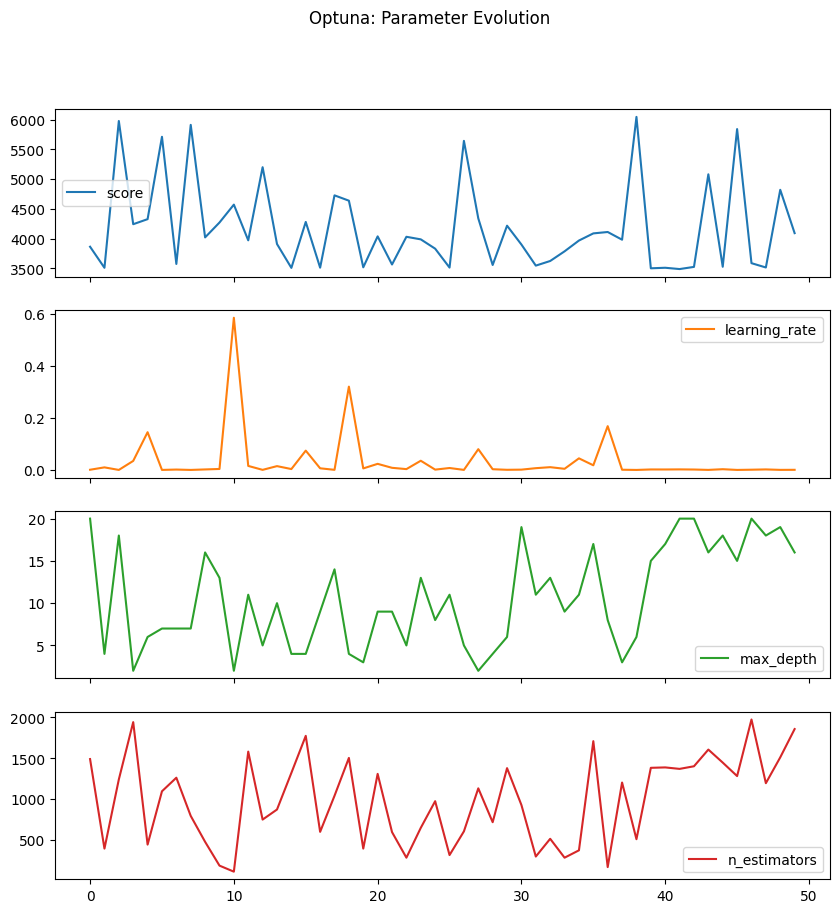

In [ ]:
# Convert Optuna results to DataFrame
optuna_results_df = pd.DataFrame({
    'score': [trial.value for trial in study.trials],
    'learning_rate': [trial.params['learning_rate'] for trial in study.trials],
    'max_depth': [trial.params['max_depth'] for trial in study.trials],
    'n_estimators': [trial.params['n_estimators'] for trial in study.trials]
})

# Visualize parameter exploration process (same format as other algorithms)
optuna_results_df.plot(subplots=True, figsize=(10, 10), title='Optuna: Parameter Evolution')

# 4️⃣ Bayesian Optimization (베이지안 최적화)

## 🔍 핵심 개념

**이전 결과를 확률 모델로 학습**하여 최적값을 지능적으로 찾는 방법

```
Random/Grid Search: 과거 결과 무시
Bayesian Optimization: 과거 결과를 학습해서 가장 유망한 영역을 전략적으로 탐색
```

**수식**: $P(\text{성능점수} | \text{하이퍼파라미터})$ - 확률 모델로 관계 추정

![](https://github.com/hyeonsangjeon/Hyperparameters-Optimization/blob/master/pic/BayesianOpt.gif?raw=true)

<img src="https://github.com/hyeonsangjeon/Hyperparameters-Optimization/blob/master/pic/bayesopt2.png?raw=true" style="height:320px;"  />

## 🧩 핵심 구성요소

### 1. Surrogate Model (대리 모델)

지금까지 조사한 점들 $(x_1, f(x_1)), ..., (x_t, f(x_t))$ 를 기반으로 목적 함수를 **확률적으로 추정**하는 모델

- 실제 목적 함수보다 **계산 비용 훨씬 저렴**
- 전체 파라미터 공간의 성능을 예측

### 2. Acquisition Function (획득 함수)

다음에 시도할 후보 $x_{t+1}$ 을 추천하는 함수

- 일반적으로 **Expected Improvement (EI)** 사용
- 탐색(Exploration)과 활용(Exploitation)의 균형 조절

## ⚙️ 알고리즘 흐름

1. 무작위 초기점 $x^*$ 생성
2. $f(x^*)$ 계산
3. 과거 결과로 조건부 확률 모델 $P(f | x)$ 구축 (Surrogate Model)
4. $P(f | x)$ 에 따라 $f(x_i)$ 개선 확률이 가장 높은 $x_i$ 선택 (Acquisition Function)
5. 실제 $f(x_i)$ 값 계산
6. 최대 반복 횟수에 도달할 때까지 3~5단계 반복

## ⚖️ 장단점

### ✅ 장점

| 항목 | 설명 |
|------|------|
| 🧠 **지능적 탐색** | 이전 결과 학습 → 유망 영역 집중 |
| ⚡ **효율성** | 적은 반복으로 최적값 도달 |
| 📏 **연속 공간** | 연속 파라미터 공간에서 효과적 |

### ❌ 단점

| 항목 | 설명 |
|------|------|
| ⏰ **초기 비용** | Surrogate 모델 구축 시간 필요 |
| 🔢 **고차원 한계** | 파라미터 20개 이상 시 효율 감소 |
| 🎓 **구현 복잡도** | Random Search보다 이해/구현 어려움 |

## 💡 이 튜토리얼 설정

```
라이브러리: scikit-optimize (skopt)의 BayesSearchCV
시도 횟수: 50회 (Random Search와 동일)
탐색 범위:
  - learning_rate: 10⁻⁵ ~ 1.0
  - n_estimators: 100 ~ 2000
  - max_depth: 2 ~ 20
```

### 📚 참고자료

- [Bayesian Optimization for Robots (Kaggle)](https://www.kaggle.com/artgor/bayesian-optimization-for-robots)
- [scikit-optimize Documentation](https://scikit-optimize.github.io/)

In [ ]:
#! pip install scikit-optimize
#https://towardsdatascience.com/hyperparameter-optimization-with-scikit-learn-scikit-opt-and-keras-f13367f3e796
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer


In [ ]:
%%time

# 1. Define search space
search_space = {
    'learning_rate': np.logspace(-5, 0, 100),  # 10^-5 ~ 1.0 (log scale)
    "max_depth": Integer(2, 20),                # 2 ~ 20 (integer range)
    'n_estimators': Integer(100, 2000),         # 100 ~ 2000 (integer range)
    'random_state': [random_state]
}

# 2. Define callback function (early termination)
def on_step(optim_result):
    """
    Callback function called at each Bayesian Optimization iteration
    Terminates optimization early when target performance reached
    """
    score = optim_result.fun  # Minimum value so far (negative MSE)
    print(f"Best score: {score:.3f}")
    
    # Terminate early if MSE better than 2800
    if score < -2800:
        print('Target performance reached! Stopping optimization.')
        return True

# 3. Create and execute BayesSearchCV object
bayes_search = BayesSearchCV(
    model, 
    search_space, 
    n_iter=n_iter,                          # 50 iterations
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=kf,                                  # 2-fold CV (same as other algorithms)
    random_state=random_state
)

# 4. Execute optimization (early termination possible with callback)
bayes_search.fit(train_data, train_targets, callback=on_step)

# 5. Test set evaluation
bayes_test_score = mean_squared_error(test_targets, bayes_search.predict(test_data))

# 6. Print results (same format as baseline)
print('=' * 50)
print('Bayesian Optimization Results')
print('=' * 50)
print(f'Optimal MSE (CV): {-bayes_search.best_score_:.2f}')
print(f'Test MSE: {bayes_test_score:.2f}')
print(f'Optimal Parameters:')
for param, value in bayes_search.best_params_.items():
    if param != 'random_state':
        print(f'  - {param}: {value}')
print('=' * 50)

In [ ]:
# Convert Bayesian Optimization results to DataFrame
bayes_results_df = pd.DataFrame({
    'score': -bayes_search.cv_results_['mean_test_score'],
    'learning_rate': bayes_search.cv_results_['param_learning_rate'].data,
    'max_depth': bayes_search.cv_results_['param_max_depth'].data,
    'n_estimators': bayes_search.cv_results_['param_n_estimators'].data
})

# Visualize parameter exploration process (same format as other algorithms)
bayes_results_df.plot(subplots=True, figsize=(10, 10), title='Bayesian Optimization: Parameter Evolution')

# 5️⃣ Hyperopt (TPE 구현체)

## 🔍 개요

**Hyperopt**는 TPE (Tree-structured Parzen Estimator) 알고리즘을 구현한 Python 라이브러리입니다.

- **GitHub**: [hyperopt/hyperopt](https://github.com/hyperopt/hyperopt)
- **특징**: 베이지안 최적화 기반 자동 하이퍼파라미터 탐색
- **장점**: sklearn 독립적으로 작동, 유연한 탐색 공간 정의 가능

## 🧩 주요 구성요소

| 함수/클래스 | 역할 | 설명 |
|-----------|-----|------|
| **fmin** | 메인 최적화 함수 | 목적 함수를 최소화하는 최적 파라미터 탐색 |
| **tpe.suggest** | TPE 알고리즘 | 베이지안 최적화 전략 (권장) |
| **hp** | 탐색 공간 정의 | 파라미터 분포 지정 (uniform, loguniform 등) |
| **Trials** | 실행 로그 | 모든 시도의 결과 저장 |

**설치:**
```bash
pip install hyperopt
```

In [ ]:
#!pip install hyperopt

## 📦 Hyperopt 라이브러리 임포트

필수 함수들을 가져옵니다:
- **fmin**: 하이퍼파라미터 최적화 실행
- **tpe**: TPE 알고리즘 (베이지안 최적화)
- **hp**: 파라미터 탐색 공간 정의 (quniform, loguniform 등)
- **Trials**: 실행 결과 로깅 및 추적

In [ ]:
from hyperopt import fmin, tpe, hp, anneal, Trials

## 🎯 목적 함수 구현

sklearn과 달리 Hyperopt는 **목적 함수를 직접 정의**해야 합니다. 아래 함수는 파라미터를 받아 모델을 학습하고 MSE를 반환합니다.

In [ ]:
def gb_mse_cv(params, random_state=random_state, cv=kf, X=train_data, y=train_targets):
    """
    Hyperopt objective function: Trains LGBMRegressor with given parameters and returns MSE
    
    Args:
        params (dict): Hyperparameters to optimize (n_estimators, max_depth, learning_rate)
        
    Returns:
        float: Cross-validation MSE (minimization target)
    """
    # 1. Convert parameters to integers and organize
    model_params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']), 
        'learning_rate': params['learning_rate'],
        'random_state': random_state,
        'verbose': -1
    }
    
    # 2. Create model
    model = LGBMRegressor(**model_params)
    
    # 3. Perform cross-validation and calculate MSE
    score = -cross_val_score(
        model, X, y, 
        cv=cv, 
        scoring="neg_mean_squared_error", 
        n_jobs=-1
    ).mean()

    return score

## 🌳 Tree-structured Parzen Estimator (TPE)

### 📄 연구 논문
[Algorithms for Hyper-Parameter Optimization (Bergstra et al., NIPS 2011)](https://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf)

<img src="https://github.com/hyeonsangjeon/Hyperparameters-Optimization/blob/master/pic/TPE.gif?raw=true" />

## 🔍 핵심 개념

TPE는 **Hyperopt의 핵심 알고리즘**으로, 베이지안 최적화를 구현한 방법입니다.

**핵심 아이디어:**
- 이전 시도 결과를 학습하여 **다음에 시도할 파라미터를 지능적으로 예측**
- 성능이 좋은 파라미터 영역과 나쁜 영역을 확률적으로 구분
- 유망한 영역에 집중하면서도 새로운 영역 탐색 (Exploration & Exploitation)

## ⚙️ 알고리즘 흐름

1. **초기화**: 무작위 초기점 $x^*$ 생성
2. **평가**: $F(x^*)$ 계산 (교차 검증 수행)
3. **모델 구축**: 과거 시도 기록으로 조건부 확률 모델 $P(F | x)$ 생성
4. **다음 후보 선택**: $P(F | x)$ 기반으로 $F(x_i)$ 개선 확률이 가장 높은 $x_i$ 선택
5. **실제 평가**: $F(x_i)$ 의 실제 값 계산
6. **반복**: 최대 반복 횟수까지 3~5단계 반복

## ⚖️ Bayesian Optimization과 비교

| 구분 | Bayesian Optimization (skopt) | TPE (Hyperopt) |
|-----|------------------------------|----------------|
| **대리 모델** | Gaussian Process (GP) | Tree-structured Parzen Estimator |
| **계산 복잡도** | O(n³) - 고차원에서 느림 | O(n) - 고차원에서도 빠름 |
| **파라미터 독립성** | 상관관계 고려 | 조건부 독립 가정 |
| **적용 시나리오** | 파라미터 < 10개 | 파라미터 > 10개 |

### 💡 실무 활용 팁

1. **고차원 문제**: 파라미터 10개 초과 시 TPE가 Bayesian Optimization보다 효율적
2. **빠른 피드백**: TPE는 모델 구축이 빠름, 빠른 반복을 선호할 때 유리
3. **유연한 탐색 공간**: 조건부 파라미터 정의 가능 (예: 레이어 수에 따라 다른 파라미터)

### 📚 참고자료

- [TPE 알고리즘 상세 설명 (Towards Data Science)](https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f)
- [Hyperopt 공식 문서](https://github.com/hyperopt/hyperopt)

## ▶️ TPE 실행

Hyperopt의 `fmin` 함수를 사용하여 TPE 최적화를 수행합니다. Random Search와 동일한 조건(50회 반복)으로 비교합니다.

In [ ]:
%%time

# 1. Define search space
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 2000, 1),  # 100 ~ 2000 (integer)
    'max_depth': hp.quniform('max_depth', 2, 20, 1),            # 2 ~ 20 (integer)
    'learning_rate': hp.loguniform('learning_rate', -5, 0)      # 10^-5 ~ 1.0 (log scale)
}

# 2. Create Trials object (for logging)
trials = Trials()

# 3. Set random seed (reproducibility)
np.random.seed(random_state)

# 4. Execute TPE optimization
best = fmin(
    fn=gb_mse_cv,           # Objective function to minimize
    space=space,            # Search space
    algo=tpe.suggest,       # TPE algorithm
    max_evals=n_iter,       # Maximum iterations (50)
    trials=trials           # Result logging
)

# 5. Train final model with optimal parameters
best_params_tpe = {
    'n_estimators': int(best['n_estimators']),
    'max_depth': int(best['max_depth']),
    'learning_rate': best['learning_rate'],
    'random_state': random_state,
    'verbose': -1
}

tpe_model = LGBMRegressor(**best_params_tpe)
tpe_model.fit(train_data, train_targets)

# 6. Test set evaluation
tpe_test_score = mean_squared_error(test_targets, tpe_model.predict(test_data))

# 7. Print results (same format as baseline)
print('=' * 50)
print('TPE (Hyperopt) Optimization Results')
print('=' * 50)
print(f'Optimal MSE (CV): {gb_mse_cv(best):.2f}')
print(f'Test MSE: {tpe_test_score:.2f}')
print(f'Optimal Parameters:')
for param, value in best.items():
    print(f'  - {param}: {value:.6f}' if isinstance(value, float) else f'  - {param}: {int(value)}')
print('=' * 50)

### 📊 TPE 결과 분석

TPE는 Random Search보다 **적은 반복으로 더 나은 하이퍼파라미터 조합**을 찾는 경향이 있습니다.

- **베이지안 접근**: 이전 시도 결과를 학습하여 다음에 시도할 파라미터를 똑똑하게 선택
- **효율적 탐색**: 동일한 50회 반복에도 Random Search보다 높은 품질의 해로 수렴할 가능성 높음
- **균형잡힌 성능**: 계산 시간은 약간 증가하지만, 성능 향상이 충분하여 실무에서 자주 사용

아래 그래프는 TPE의 수렴 과정을 보여주며, 반복이 진행될수록 **점수가 점진적으로 감소(개선)**하는 것을 확인할 수 있습니다.

In [ ]:
# Convert TPE (Hyperopt) search results to DataFrame
tpe_results = np.array([
    [x['result']['loss'],
     x['misc']['vals']['learning_rate'][0],
     x['misc']['vals']['max_depth'][0],
     x['misc']['vals']['n_estimators'][0]]
    for x in trials.trials
])

tpe_results_df = pd.DataFrame(
    tpe_results,
    columns=['score', 'learning_rate', 'max_depth', 'n_estimators']
)

# Visualize parameter exploration process (same format as other algorithms)
tpe_results_df.plot(subplots=True, figsize=(10, 10), title='TPE (Hyperopt): Parameter Evolution')

## Results

모든 기법의 **반복에 따른 최적 성능(누적 최고 점수) 변화**를 하나의 그래프에서 비교합니다.

- y축은 각 알고리즘이 지금까지 찾은 **최고(최소) MSE 값의 추이**를 나타냄
- 곡선이 빠르고 낮게 내려갈수록 **적은 시도로 더 좋은 하이퍼파라미터를 발견**한 것
- **Baseline** 곡선은 튜닝하지 않은 고정 MSE이며, 다른 곡선들이 이 선 아래로 얼마나 떨어지는지가 **튜닝으로 얻은 이득(성능 개선)**
- 이 그래프를 통해 **각 기법이 Baseline 대비 얼마나 개선되었는지**, 그리고 Grid/Random/Optuna/Bayesian/TPE 간 **수렴 속도와 최종 성능**을 직관적으로 비교할 수 있습니다.

In [ ]:
# Compare best cumulative score changes over iterations for all algorithms
scores_df = pd.DataFrame(index=range(n_iter))
scores_df['Baseline'] = baseline_mse
scores_df['Grid Search'] = gs_results_df['score'].cummin()
scores_df['Random Search'] = rs_results_df['score'].cummin()
# scores_df['Hyperband'] = hb_results_df['score'].cummin()  # Activate if needed
scores_df['Optuna'] = optuna_results_df['score'].cummin()
scores_df['Bayesian Optimization'] = bayes_results_df['score'].cummin()
scores_df['TPE'] = tpe_results_df['score'].cummin()

# Visualize convergence curves
ax = scores_df.plot(figsize=(10, 6))
ax.set_xlabel('Number of iterations')
ax.set_ylabel('Best cumulative score (MSE)')
ax.set_title('Hyperparameter Optimization: Best Score over Iterations')
ax.legend(loc='best')

### 📊 결과 분석

#### 🏆 알고리즘 성능 비교

**Baseline 대비 개선:**
- 모든 최적화 알고리즘이 Baseline보다 **현저히 낮은 MSE** 달성 → 하이퍼파라미터 튜닝 효과 명확

**알고리즘 특성:**

| 알고리즘 | 수렴 속도 | 최종 성능 | 계산 비용 | 추천 상황 |
|---------|----------|----------|----------|----------|
| **Grid Search** | 느림 | 좋음 | 높음 | 파라미터 공간 작고 정밀 탐색 필요 시 |
| **Random Search** | 빠름 | 좋음 | 낮음 | 빠른 프로토타입, 초기 실험 |
| **Optuna** | 매우 빠름 | 매우 좋음 | 중간 | **균형잡힌 선택** - 대부분의 경우 추천 |
| **Bayesian Opt** | 중간 | 매우 좋음 | 높음 | 파라미터 < 10개, 최고 성능 필요 |
| **TPE** | 빠름 | 매우 좋음 | 중간 | 파라미터 > 10개, 고차원 문제 |

#### 💡 실무 적용 가이드

**상황별 추천:**
1. **⚡ 빠른 프로토타입** (시간 제약)
   - 우선순위 1: **Random Search** - 간단하고 빠름
   - 우선순위 2: **Optuna** - 약간의 시간으로 더 나은 결과

2. **🎯 최고 성능 필요** (시간 여유)
   - 파라미터 < 10개: **Bayesian Optimization**
   - 파라미터 ≥ 10개: **TPE (Hyperopt)** 또는 **Optuna**

3. **⚖️ 균형잡힌 선택** (실무 추천)
   - **Optuna (TPE + Pruning)** - 속도와 성능의 최적 균형

4. **🚀 시간/리소스 제한**
   - **Optuna의 Pruning 기능 활용** - 불필요한 시도 조기 종료

#### ⚠️ 주의사항

**그래프 해석 시 유의점:**
- 이 실험은 **작은 데이터셋(442개 샘플), 2-Fold CV, 50회 반복**으로 수행
- `random_state` 값에 따라 결과가 크게 달라질 수 있음
- 실제 환경에서는 더 많은 fold(5-fold 이상)와 반복 횟수 권장

**Toy 데이터셋 특성:**
- 작은 데이터셋(442개)에서는 **과적합이 쉽게 발생**
- CV MSE가 높은데 test MSE가 낮을 때 → 테스트 세트가 우연히 쉽거나 데이터가 너무 작아서일 수 있음
- 실제 프로젝트에서는 **더 큰 데이터셋으로 검증 필요**

**실무 평가 기준:**
- 이 튜토리얼: 반복 횟수 기준 비교 (교육 목적)
- 실제 환경: **실제 소요 시간** 기준 평가가 더 정확

## 🧪 테스트 데이터 성능 비교

모든 알고리즘의 **테스트 세트 MSE**를 출력하여 실제 성능을 검증합니다.

### 📋 비교 항목
- **교차 검증 MSE**: 각 알고리즘이 학습 중 얻은 최적 성능 (위 그래프 참고)
- **테스트 MSE**: 보지 못한 테스트 데이터에 대한 실제 예측 성능 (아래 출력)

### 💡 해석 가이드
- **CV MSE < Test MSE**: 정상적인 경우 - 학습 데이터에서 더 좋은 성능
- **CV MSE ≈ Test MSE**: 이상적 - 일반화 성능 우수
- **CV MSE > Test MSE**: Toy 데이터셋 특성 - 테스트 세트가 우연히 쉬웠을 가능성

In [ ]:
# Test set performance comparison (including baseline)
print('=' * 50)
print('Test Set MSE Comparison')
print('=' * 50)
print(f"Baseline (no tuning)    : {baseline_mse:.3f}")
print('-' * 50)
print(f"Grid Search             : {gs_test_score:.3f}")
print(f"Random Search           : {rs_test_score:.3f}")
print(f"Optuna                  : {optuna_test_score:.3f}")
print(f"Bayesian Optimization   : {bayes_test_score:.3f}")
print(f"TPE (Hyperopt)          : {tpe_test_score:.3f}")
print('=' * 50)

# Calculate improvement rate vs baseline
print('\nImprovement Rate vs Baseline:')
print('=' * 50)
for name, score in [
    ('Grid Search', gs_test_score),
    ('Random Search', rs_test_score),
    ('Optuna', optuna_test_score),
    ('Bayesian Optimization', bayes_test_score),
    ('TPE (Hyperopt)', tpe_test_score)
]:
    improvement = ((baseline_mse - score) / baseline_mse) * 100
    print(f"{name:25s}: {improvement:+.2f}%")
print('=' * 50)

## 🎓 최종 결론

### 🏆 알고리즘 특성 요약

| 알고리즘 | 추천 상황 | 장점 | 단점 |
|---------|----------|-----|------|
| **Optuna** | **대부분의 경우** | 속도와 성능의 최적 균형 | 초기 설정 필요 |
| **Random Search** | 빠른 실험 | 간단하고 빠름 | 최고 성능 보장 안 됨 |
| **TPE (Hyperopt)** | 고차원 파라미터 | 많은 파라미터에 효과적 | 학습 곡선 존재 |
| **Bayesian Opt** | 최고 성능 필요 | 높은 최종 성능 | 긴 계산 시간 |
| **Grid Search** | 작은 탐색 공간 | 완전 탐색 보장 | 높은 시간 소요 |

### 💡 실무 선택 가이드

**시간 제약이 있을 때:**
- Random Search로 시작 → 좋은 범위 찾기 → Optuna로 정밀 탐색

**최고 성능이 필요할 때:**
- 파라미터 < 10개: Bayesian Optimization
- 파라미터 ≥ 10개: TPE 또는 Optuna

**대부분의 경우:**
- **Optuna** 사용 - 현대적이고, 활발히 유지보수되며, 강력함

### ⚠️ 중요 공지

이 실험은 **교육 목적의 toy 데이터셋**으로 수행되었습니다 (442개 샘플, 2-fold CV).

**실제 프로젝트에서는:**
- 더 많은 데이터 (최소 수천 개 샘플)
- 더 많은 fold (5-fold 이상)
- 여러 random_state로 검증
- 실제 소요 시간 기준 평가

권장합니다.

## 📚 튜토리얼 요약

### 🎯 비교한 5가지 최적화 알고리즘

| 번호 | 알고리즘 | 핵심 특징 | 실무 평가 |
|-----|---------|----------|-----------|
| 1 | **Grid Search** | 모든 조합 완전 탐색 | ⭐⭐ (작은 공간만) |
| 2 | **Random Search** | 무작위 샘플링 | ⭐⭐⭐⭐ (빠른 시작) |
| 3 | **Optuna** | TPE + Pruning 결합 | ⭐⭐⭐⭐⭐ (최고 균형) |
| 4 | **Bayesian Opt** | Gaussian Process 기반 | ⭐⭐⭐⭐ (높은 성능) |
| 5 | **TPE (Hyperopt)** | 베이지안 최적화 변형 | ⭐⭐⭐⭐ (고차원) |

### 💡 상황별 선택 가이드

**프로젝트 시작 단계:**
1. Random Search로 좋은 파라미터 범위 파악 (1시간)
2. Optuna로 좁은 범위 정밀 탐색 (2-3시간)
3. 필요시 최종 미세 조정 (추가 1시간)

**시간별 권장사항:**
- ⚡ **30분 이내**: Random Search (50회 반복)
- 🎯 **1-2시간**: Optuna (100회 반복 + Pruning)
- 🏆 **3시간 이상**: Bayesian Opt 또는 TPE (200회 이상)

**파라미터 개수별:**
- 파라미터 < 5개: Grid Search도 가능
- 파라미터 5-10개: Bayesian Optimization 또는 Optuna
- 파라미터 > 10개: **TPE** 또는 **Optuna** (필수)

### 🚀 핵심 교훈

**"완벽한" 알고리즘은 없습니다.**
- 상황에 따라 Random Search가 Bayesian보다 나을 수 있음
- 중요한 것은 **투입 시간 대비 성능 향상**
- 대부분의 경우 **Optuna가 가장 실용적**

**실무 팁:**
1. 먼저 베이스라인 측정 (개선 효과 확인)
2. 적은 반복으로 시작 → 점진적 확대
3. 시각화로 탐색 과정 모니터링
4. 실제 소요 시간 기준 평가

---

이 튜토리얼이 여러분의 ML/DL 프로젝트에서 **하이퍼파라미터 최적화 시간을 획기적으로 단축**하는데 도움이 되길 바랍니다! 🎉